
# Prediction Biological Activity with CatBoost Implementation

*The main goal of this project is prediction biological activity for inhibiting GPCR-mediated pheromone signaling in the invasive sea lamprey using the dataset created from the ligand-based screening dataset.*


# Results

- Matthews Correlation Coefficient(MCC) : 0.8257228
- Test Accuracy score : 92.857%

# References

- Raschka, S., Scott, A.M., Huertas, M., Li, W., Kuhn, L.A. (2018). Automated Inference of Chemical Discriminants of Biological Activity. In: Gore, M., Jagtap, U. (eds) Computational Drug Discovery and Design. Methods in Molecular Biology, vol 1762. Humana Press, New York, NY. https://doi.org/10.1007/978-1-4939-7756-7_16

- original code and data -> https://github.com/psa-lab/predicting-activity-by-machine-learning



In [1]:
!pip install catboost
!pip install ppscore

In [2]:
# importing dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, cv, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import ppscore as pps

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GeneralDB/dkpes.csv')
data.head()

,index,Signal-inhibition,3-Keto,3-Hydroxy,12-Keto,12-Hydroxy,19-Methyl,18-Methyl,Sulfate-Ester,Sulfate-Oxygens,...,FitTverskyCombo,FitTversky,FitColorTversky,RefTverskyCombo,RefTversky,RefColorTversky,ScaledColor,ComboScore,ColorScore,Overlap
0,ENE4,0.905,1,0,0,1,1,1,1,3,...,1.624,0.932,0.692,1.811,0.951,0.860,0.872,1.761,-9.590,1286.317
1,ZINC72400307,0.904,0,0,0,1,1,1,1,3,...,1.401,0.888,0.513,1.579,0.901,0.678,0.691,1.499,-7.596,1218.799
2,ENE3,0.897,1,0,0,1,1,1,1,3,...,1.704,0.970,0.734,1.905,0.992,0.912,0.925,1.887,-10.171,1341.629
3,ENE1,0.893,1,0,1,0,1,1,1,3,...,1.822,0.976,0.846,1.985,1.002,0.983,0.992,1.970,-10.911,1357.732
4,ENE2,0.845,1,0,1,0,1,1,1,3,...,1.786,0.967,0.820,1.949,0.997,0.953,0.961,1.925,-10.574,1351.912


In [4]:
# I have applied to the mutual information due to find the most valuable features

numeric_data = data.copy()
numeric_data.drop('ShapeQuery', axis = 1, inplace = True)

mi = mutual_info_regression(numeric_data.iloc[:,2:-1], y = numeric_data['Signal-inhibition'] )

mi = pd.DataFrame(mi, columns = ["miScore"] ,index = list(numeric_data.iloc[:,2:-1].columns))
mi[mi['miScore'] > 0.12].sort_values(by = 'miScore', ascending = False)

,miScore
Sulfur,0.266799
ComboScore,0.251659
TanimotoCombo,0.228881
ColorScore,0.203204
ScaledColor,0.198036
RefColorTversky,0.191372
Sulfate-Ester,0.175698
ShapeTanimoto,0.166892
Sulfate-Oxygens,0.164018


In [5]:
# 1 active, 0 non-active, the referance is the paper.

def create_cat_func(X):
  if X <= 0.6:
    return 0
  else:
    return 1

data['Signal-inhibition'] = data['Signal-inhibition'].apply(create_cat_func)


In [6]:
y = data['Signal-inhibition']
X = data.drop(['Signal-inhibition'], axis = 1)

X.head()

,index,3-Keto,3-Hydroxy,12-Keto,12-Hydroxy,19-Methyl,18-Methyl,Sulfate-Ester,Sulfate-Oxygens,C4-C5-DB,...,FitTverskyCombo,FitTversky,FitColorTversky,RefTverskyCombo,RefTversky,RefColorTversky,ScaledColor,ComboScore,ColorScore,Overlap
0,ENE4,1,0,0,1,1,1,1,3,0,...,1.624,0.932,0.692,1.811,0.951,0.860,0.872,1.761,-9.590,1286.317
1,ZINC72400307,0,0,0,1,1,1,1,3,0,...,1.401,0.888,0.513,1.579,0.901,0.678,0.691,1.499,-7.596,1218.799
2,ENE3,1,0,0,1,1,1,1,3,1,...,1.704,0.970,0.734,1.905,0.992,0.912,0.925,1.887,-10.171,1341.629
3,ENE1,1,0,1,0,1,1,1,3,1,...,1.822,0.976,0.846,1.985,1.002,0.983,0.992,1.970,-10.911,1357.732
4,ENE2,1,0,1,0,1,1,1,3,1,...,1.786,0.967,0.820,1.949,0.997,0.953,0.961,1.925,-10.574,1351.912


In [7]:
# define cat features

cat_feat_idx =  np.where(X.dtypes == 'object')[0]
cat_feat_idx

array([ 0, 12])

In [8]:
# class distributions

y.value_counts()

0    44
1    12
Name: Signal-inhibition, dtype: int64

In [9]:
# train-test splitting

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify= y, random_state=0)

In [10]:
# creating the model and training

model = CatBoostClassifier(iterations = 1000, cat_features = cat_feat_idx, verbose = 250, max_depth = 5)

model.fit(X_train, y_train)

Learning rate set to 0.002661
0:	learn: 0.6902634	total: 51.2ms	remaining: 51.1s
250:	learn: 0.3226209	total: 577ms	remaining: 1.72s
500:	learn: 0.1929450	total: 1.12s	remaining: 1.12s
750:	learn: 0.1327710	total: 2.19s	remaining: 726ms
999:	learn: 0.0946001	total: 3.53s	remaining: 0us


In [11]:
# predicting and calculating some classification metrics (mcc, acc etc.)

pred = model.predict(X_test)

report = classification_report(y_test, pred)
matthews_Coef = matthews_corrcoef(y_test, pred)
acc_scr = accuracy_score(y_test, pred)*100

print("matthews_Coef :" + str(matthews_Coef))
print('accuracy score:{0:.3f}%'.format(acc_scr))
print(report)

matthews_Coef :0.8257228238447705
accuracy score:92.857%
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.75      1.00      0.86         3

    accuracy                           0.93        14
   macro avg       0.88      0.95      0.90        14
weighted avg       0.95      0.93      0.93        14



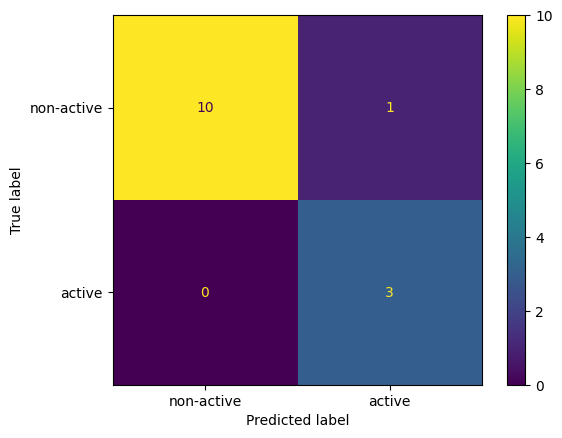

In [12]:
# plotting confusion matrix

cm =  confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(cm, display_labels=['non-active','active'])
disp.plot()

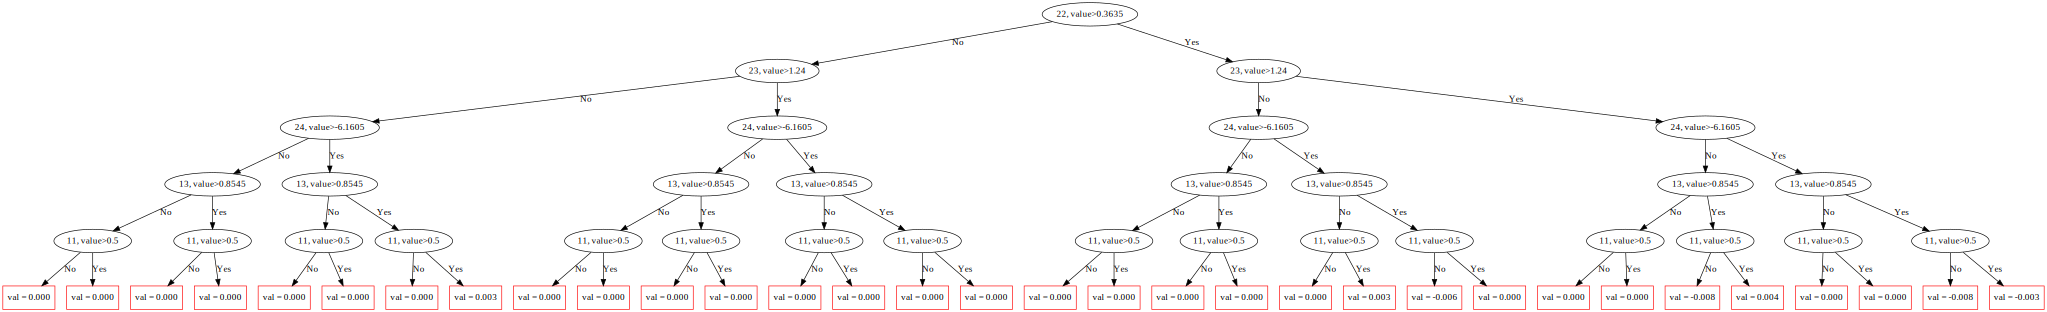

In [13]:
# plotting the first tree

model.plot_tree(tree_idx = 0)

In [14]:
# catboosting cross-validation wiht 6 folds

cv_pool = Pool(X, y, cat_features = cat_feat_idx )


cv_params = {
    "iterations" : 1000,
    "loss_function": "CrossEntropy",
    "verbose": 250
    }


CV_scores = cv(cv_pool, params = cv_params, fold_count =6 )

Training on fold [0/6]
0:	learn: 0.6658817	test: 0.6715721	best: 0.6715721 (0)	total: 10.8ms	remaining: 10.7s
250:	learn: 0.0228609	test: 0.1644296	best: 0.1644296 (250)	total: 1.44s	remaining: 4.31s
500:	learn: 0.0087601	test: 0.1264770	best: 0.1264770 (500)	total: 3s	remaining: 2.99s
750:	learn: 0.0053423	test: 0.1139476	best: 0.1139476 (750)	total: 4.41s	remaining: 1.46s
999:	learn: 0.0039177	test: 0.1045575	best: 0.1045575 (999)	total: 5.81s	remaining: 0us

bestTest = 0.1045575398
bestIteration = 999

Training on fold [1/6]
0:	learn: 0.6675095	test: 0.6768082	best: 0.6768082 (0)	total: 5.48ms	remaining: 5.47s
250:	learn: 0.0144329	test: 0.6214416	best: 0.4214194 (58)	total: 1.71s	remaining: 5.1s
500:	learn: 0.0065076	test: 0.7832529	best: 0.4214194 (58)	total: 3.46s	remaining: 3.44s
750:	learn: 0.0042386	test: 0.8606267	best: 0.4214194 (58)	total: 4.75s	remaining: 1.57s
999:	learn: 0.0031537	test: 0.9112886	best: 0.4214194 (58)	total: 6.15s	remaining: 0us

bestTest = 0.4214193664
b

In [15]:
CV_scores.sort_values(by = "test-CrossEntropy-mean").head()

,iterations,test-CrossEntropy-mean,test-CrossEntropy-std,train-CrossEntropy-mean,train-CrossEntropy-std
71,71,0.315119,0.146117,0.109098,0.016827
72,72,0.315515,0.147204,0.106898,0.016498
70,70,0.315780,0.145474,0.110695,0.016610
76,76,0.315811,0.151348,0.100607,0.015959
75,75,0.315919,0.150768,0.102312,0.016368
